In [1]:
#importing general libraries needed to work with the data.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy.stats import chi2_contingency
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [2]:
#importing natural language processing libraries to work with different word
import random 
import re
import pickle
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import digits, punctuation
from wordcloud import WordCloud, STOPWORDS

In [3]:
#Importing Machine Learning Libraries which will be needed to work on this data
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Cleaning Data 

In [4]:
data = pd.read_csv("data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

In [5]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


#### Analysis on missing data

Text(0.5, 1.0, 'Ratio of missing values per columns')

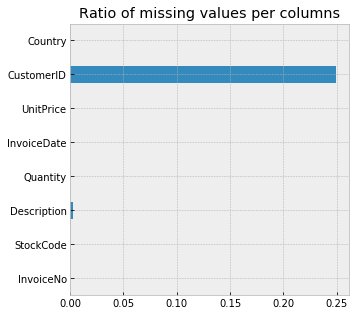

In [7]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

#### Null values in detail

In [8]:
nan_rows = data[data.isnull().T.any().T]
nan_rows.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


<h4>
Since the missing values are only in the CustomerID column and the description column, we could try to look at the InvoiceNo and see if maybe we can find the Customer ID
 </h4>

In [9]:
data[data['InvoiceNo']== '536544'][:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom


<h4>
It appears that we can't replace the missing values and we can't keep data without the value in the customer id columns since we want to classify the customers. So I'll drop the lines with missing values on the customer ID column.
</h4>

In [10]:
data = data.dropna(subset=["CustomerID"])

#### Checking if there are still any null values 

Text(0.5, 1.0, 'Ratio of missing values per columns')

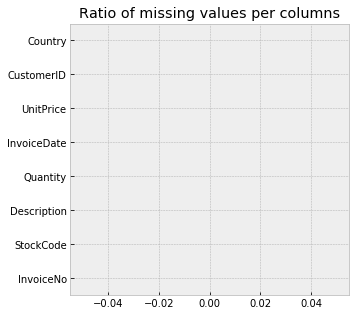

In [11]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

#### Checking Dupicate entries in the data 

In [12]:
print('Dupplicate entries: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)

Dupplicate entries: 5225


## Exploratory Data Analysis 

#### 1) Countries

In [13]:
data.Country.nunique()

37

In [14]:
customer_country=data[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


##### More than 90% of the data is coming from UK !

#### 2) Quantity

In [15]:
data.describe()

,Quantity,UnitPrice
count,401604.000000,401604.000000
mean,12.183273,3.474064
std,250.283037,69.764035
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [16]:
data[(data['Quantity']<0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom


 <ul>
  <li>The stock code values aren't only numerical, there are speciales values like D which means Discount </li>
  <li>The InvoiceNo aren't also only numerical since there is a C before the other numbers for every negative value in the quantity column, this could mean that the order was canceled.</li>

</ul> 

#### 3) InvoiceNo - Cancellation

In [17]:
# Constucting a basket for later use
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})

In [18]:
nb_products_per_basket.InvoiceNo = nb_products_per_basket.InvoiceNo.astype(str)
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
len(nb_products_per_basket[nb_products_per_basket['order_canceled']==1])/len(nb_products_per_basket)*100

16.466876971608833

<h5>It appears that more than 16% of the transactions were canceled which is significant. Let's take a look at some rows where the transaction was canceled.</h5>

In [19]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1][:5]

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


In [20]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346,United Kingdom


<h5>
By looking at these results, it appears that there is a counterpart to the canceled transaction in the database. Let's see if this is always the case.
</h5>

In [21]:
test = data[data['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  test.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(test.loc[index])
        print('Our initial hypothesis is wrong')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
Our initial hypothesis is wrong


In [22]:
data[data['CustomerID'] == '14527'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,12/5/2010 13:17,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/5/2010 13:17,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,12/5/2010 13:17,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,12/5/2010 13:17,3.95,14527,United Kingdom


<h5>
It appears that when there is a discount there are no counterparts. Let's try again but without the discount values
</h5>

In [23]:
data_check = data[(data['Quantity'] < 0) & (data['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  data_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(index, data_check.loc[index])
        print('The second hypothesis is also wrong')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
The second hypothesis is also wrong


In [24]:
data[(data['CustomerID'] == '15311') & (data['Description'] == 'SET OF 3 COLOURED  FLYING DUCKS')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/5/2010 13:55,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/8/2010 13:18,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/13/2010 15:07,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,12/20/2010 15:27,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/5/2011 11:41,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/17/2011 13:39,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2/1/2011 12:14,4.65,15311,United Kingdom


#### It seems that the customer can also cancel just a part of the transaction which is logical so we need to take this into account for later. 

In [25]:
df_cleaned = data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) & 
                         (data['InvoiceDate'] < col['InvoiceDate']) & 
                         (data['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

In [26]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 6151
doubtfull_entry: 2607


In [27]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 37


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
27329,C538530,22630,DOLLY GIRL LUNCH BOX,-33,12/13/2010 10:26,1.95,14796,United Kingdom,0
32870,C539195,22942,CHRISTMAS LIGHTS 10 SANTAS,-5,12/16/2010 12:05,8.50,12748,United Kingdom,0
33085,C539221,22941,CHRISTMAS LIGHTS 10 REINDEER,-12,12/16/2010 12:56,8.50,14911,EIRE,0
33086,C539221,22942,CHRISTMAS LIGHTS 10 SANTAS,-10,12/16/2010 12:56,8.50,14911,EIRE,0
77599,C542744,22700,BLACK AND WHITE DOG BOWL,-10,1/31/2011 16:32,0.85,16191,United Kingdom,0


In [28]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

#### 4) Stockcode 

In [29]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

##### These are specific operations which doesn't characterize our customers so I'll just drop these transactions from our database 

In [30]:
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

#### 5) Outliers

In [31]:
df_cleaned.describe()

,Quantity,UnitPrice,QuantityCanceled
count,391183.000000,391183.000000,391183.000000
mean,13.179665,2.874130,0.583911
std,181.907403,4.284639,175.868790
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,0.000000
50%,6.000000,1.950000,0.000000
75%,12.000000,3.750000,0.000000
max,80995.000000,649.500000,80995.000000


##### The minimum value for the unitprice is 0, let's see why is that.

In [32]:
df_cleaned[(df_cleaned['UnitPrice'] == 0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081,United Kingdom,0


<h5>I am tempted to replace the null values by the most common one but it might be a special discount or something else so I'll leave it like that. Here let's remove the items that got completely canceled in order to harmonize the futur clusters and not have too much special values.</h5>

## Feature Engineering

In [33]:
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(df_cleaned)

InvoiceNo :  18405
StockCode :  3659
Description :  3871
Quantity :  300
InvoiceDate :  17169
UnitPrice :  356
CustomerID :  4335
Country :  37
QuantityCanceled :  115


In [34]:
# Total price feature

df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

##### We can now look at the countries' monetary value thanks to this feature

Text(0.5, 1.0, 'Revenue per Country')

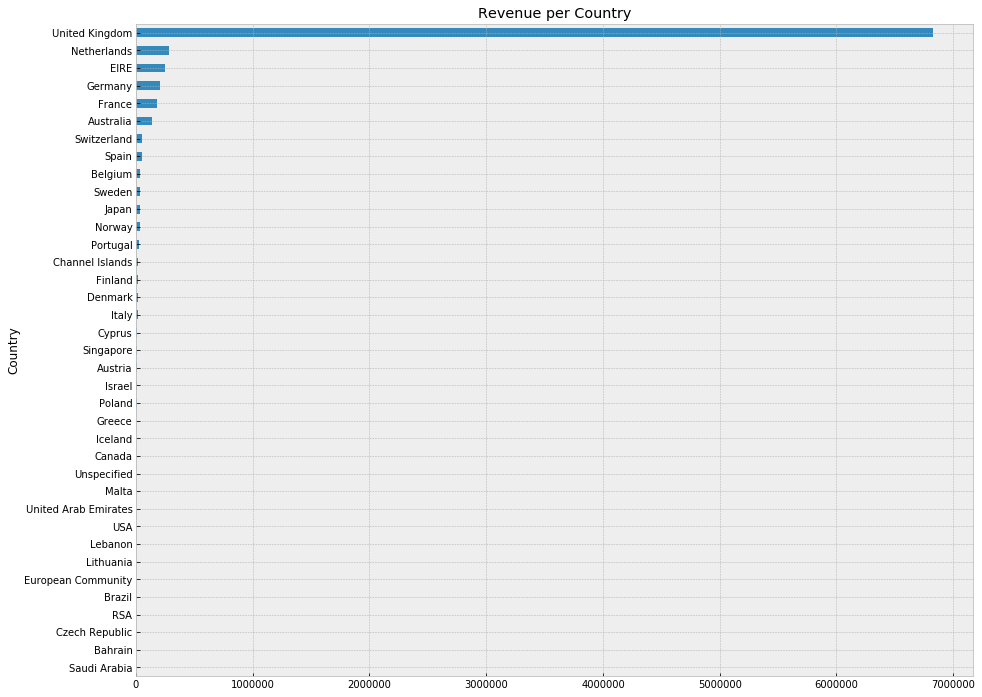

In [35]:
revenue_per_countries = df_cleaned.groupby(["Country"])["TotalPrice"].sum().sort_values()
revenue_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("Revenue per Country")

Text(0.5, 1.0, 'Number of Invoices per Country')

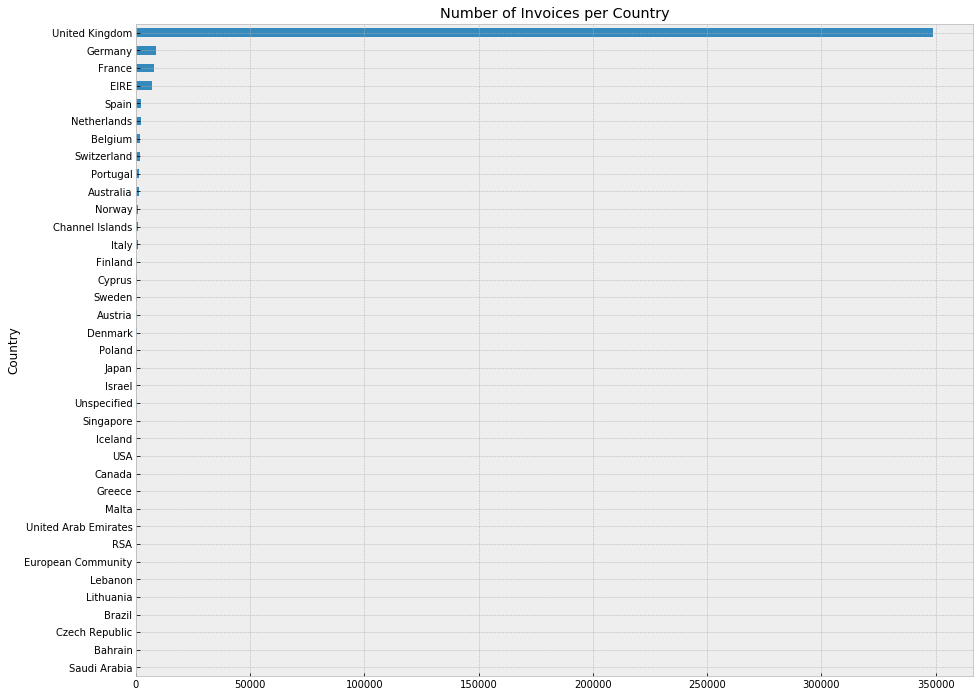

In [36]:
No_invoice_per_country = df_cleaned.groupby(["Country"])["InvoiceNo"].count().sort_values()
No_invoice_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Number of Invoices per Country")

##### This is very interesting since we can see that Netherlands is the 2nd country in value even though it has less invoices than countries like Germany or France for example and 10 times less customers. (95, 87 and 9 for Germany, France and Netherlands respectively)

In [37]:
le = LabelEncoder()
le.fit(df_cleaned['Country'])

LabelEncoder()

In [38]:
l = [i for i in range(37)]
dict(zip(list(le.classes_), l))

{'Australia': 0,
 'Austria': 1,
 'Bahrain': 2,
 'Belgium': 3,
 'Brazil': 4,
 'Canada': 5,
 'Channel Islands': 6,
 'Cyprus': 7,
 'Czech Republic': 8,
 'Denmark': 9,
 'EIRE': 10,
 'European Community': 11,
 'Finland': 12,
 'France': 13,
 'Germany': 14,
 'Greece': 15,
 'Iceland': 16,
 'Israel': 17,
 'Italy': 18,
 'Japan': 19,
 'Lebanon': 20,
 'Lithuania': 21,
 'Malta': 22,
 'Netherlands': 23,
 'Norway': 24,
 'Poland': 25,
 'Portugal': 26,
 'RSA': 27,
 'Saudi Arabia': 28,
 'Singapore': 29,
 'Spain': 30,
 'Sweden': 31,
 'Switzerland': 32,
 'USA': 33,
 'United Arab Emirates': 34,
 'United Kingdom': 35,
 'Unspecified': 36}

In [39]:
df_cleaned['Country'] = le.transform(df_cleaned['Country'])

In [40]:
with open('labelencoder.pickle', 'wb') as g:
    pickle.dump(le, g)

In [41]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,35,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,35,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,35,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,35,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,35,0,20.34


## RFM Principle 

RFM stands for Recency, Frequency and Monetary. It is a customer segmentation technique that uses past purchase behavior to divide customers into groups.

In [42]:
df_cleaned['InvoiceDate'].min()

'1/10/2011 10:32'

In [43]:
df_cleaned['InvoiceDate'].max()

'9/9/2011 9:52'

In [44]:
# I'll just fix the date to be one day after the last entry in the databse

NOW = dt.datetime(2011,12,10)
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [45]:
custom_aggregation = {}
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["TotalPrice"] = "sum"


rfmTable = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

In [46]:
rfmTable["Recency"] = NOW - rfmTable["InvoiceDate"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")

In [47]:
rfmTable.head()

,InvoiceDate,CustomerID,TotalPrice,Recency
InvoiceNo,,,,
536365,2010-12-01 08:26:00,17850,139.12,373.0
536366,2010-12-01 08:28:00,17850,22.20,373.0
536367,2010-12-01 08:34:00,13047,278.73,373.0
536368,2010-12-01 08:34:00,13047,70.05,373.0
536369,2010-12-01 08:35:00,13047,17.85,373.0


In [48]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["InvoiceDate"] = lambda x: len(x)
custom_aggregation["TotalPrice"] = "sum"

rfmTable_final = rfmTable.groupby("CustomerID").agg(custom_aggregation)

In [49]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequency", "monetary_value"]

In [50]:
rfmTable_final.head()

,min_recency,max_recency,frequency,monetary_value
CustomerID,,,,
12346,325.0,325.0,1,0.00
12347,2.0,367.0,7,4310.00
12348,75.0,358.0,4,1437.24
12349,18.0,18.0,1,1457.55
12350,310.0,310.0,1,294.40


In [51]:
first_customer = df_cleaned[df_cleaned['CustomerID']=='12747']
first_customer.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
9754,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,12747,35,0,30.60
9755,537215,85124B,BLUE JUICY FRUIT PHOTO FRAME,6,2010-12-05 15:38:00,2.55,12747,35,0,15.30
9756,537215,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2010-12-05 15:38:00,1.69,12747,35,0,27.04
9757,537215,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,2010-12-05 15:38:00,1.65,12747,35,0,39.60
9758,537215,85064,CREAM SWEETHEART LETTER RACK,6,2010-12-05 15:38:00,5.45,12747,35,0,32.70


In [52]:
quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [53]:
segmented_rfm = rfmTable_final

In [54]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

##### Here we'll apply a score on each feature of RFM

In [55]:
segmented_rfm['r_quartile'] = segmented_rfm['min_recency'].apply(RScore, args=('min_recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4
12347,2.0,367.0,7,4310.00,1,1,1
12348,75.0,358.0,4,1437.24,3,2,2
12349,18.0,18.0,1,1457.55,2,4,2
12350,310.0,310.0,1,294.40,4,4,4


##### Finally we'll set a score for each customer in the database. 

In [56]:
 segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4,444
12347,2.0,367.0,7,4310.00,1,1,1,111
12348,75.0,358.0,4,1437.24,3,2,2,322
12349,18.0,18.0,1,1457.55,2,4,2,242
12350,310.0,310.0,1,294.40,4,4,4,444


In [60]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
14646,1.0,354.0,73,278742.02,1,1,1,111
18102,0.0,367.0,60,259657.30,1,1,1,111
17450,8.0,367.0,46,193417.63,1,1,1,111
14911,1.0,373.0,198,131009.71,1,1,1,111
14156,9.0,371.0,54,113728.45,1,1,1,111


In [59]:
segmented_rfm.head(5)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4,444
12347,2.0,367.0,7,4310.00,1,1,1,111
12348,75.0,358.0,4,1437.24,3,2,2,322
12349,18.0,18.0,1,1457.55,2,4,2,242
12350,310.0,310.0,1,294.40,4,4,4,444


In [61]:
segmented_rfm = segmented_rfm.reset_index()

In [62]:
segmented_rfm.head()

,CustomerID,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
0,12346,325.0,325.0,1,0.00,4,4,4,444
1,12347,2.0,367.0,7,4310.00,1,1,1,111
2,12348,75.0,358.0,4,1437.24,3,2,2,322
3,12349,18.0,18.0,1,1457.55,2,4,2,242
4,12350,310.0,310.0,1,294.40,4,4,4,444


In [63]:
df_cleaned = pd.merge(df_cleaned,segmented_rfm, on='CustomerID')

In [64]:
df_cleaned.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'QuantityCanceled', 'TotalPrice',
       'min_recency', 'max_recency', 'frequency', 'monetary_value',
       'r_quartile', 'f_quartile', 'm_quartile', 'RFMScore'],
      dtype='object')

##### We don't need the quartiles anymore, let's drop them. 

In [65]:
df_cleaned = df_cleaned.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])

### RFM Score Classification
 This is the standard, which tells that whats we can determine from our calculated score.

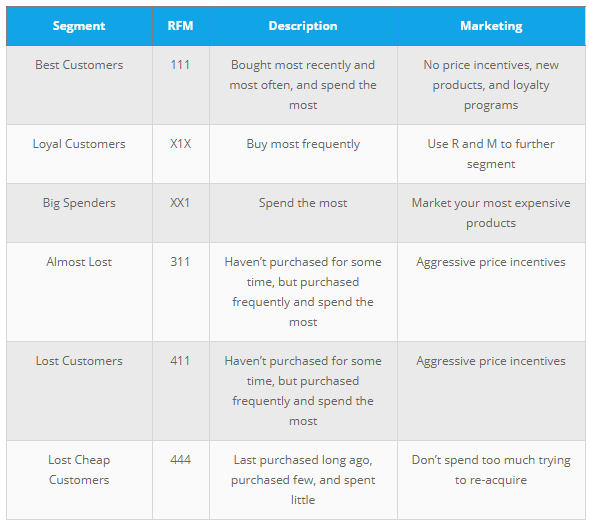

In [66]:
df_cleaned['Month'] = df_cleaned["InvoiceDate"].map(lambda x: x.month)

In [67]:
df_cleaned['Month'].value_counts()

11    62949
10    48613
12    42536
9     39510
5     27962
6     26820
3     26752
8     26688
7     26476
4     22347
1     20899
2     19631
Name: Month, dtype: int64

In [68]:
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].map(lambda x: x.weekday())
df_cleaned['Day'] = df_cleaned["InvoiceDate"].map(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].map(lambda x: x.hour)

In [69]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,35,0,15.30,372.0,373.0,34,5322.84,411,12,2,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,35,0,22.00,372.0,373.0,34,5322.84,411,12,2,1,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8


### Product Categories

In [70]:
X = df_cleaned["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_IDF_matrix : (3871, 1694) of float64


In [71]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_IDF_embedded : (3871, 100) of float64


In [72]:
score_tfidf = []

x = list(range(5, 155, 10))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)

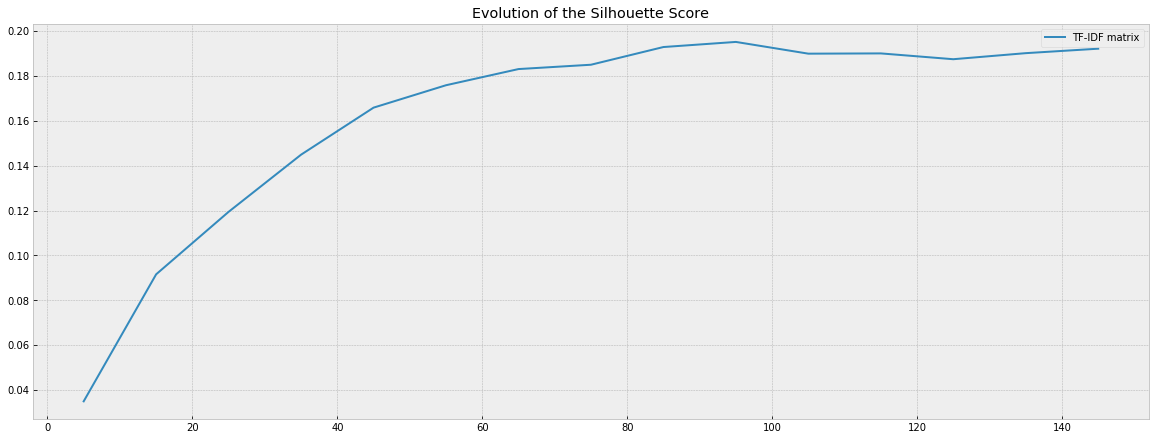

In [73]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()

##### The highest value for the silhouette score is when there are 135 clusters. So we'll choose this value.

Text(0.5, 1.0, 'ACP with 135 clusters')

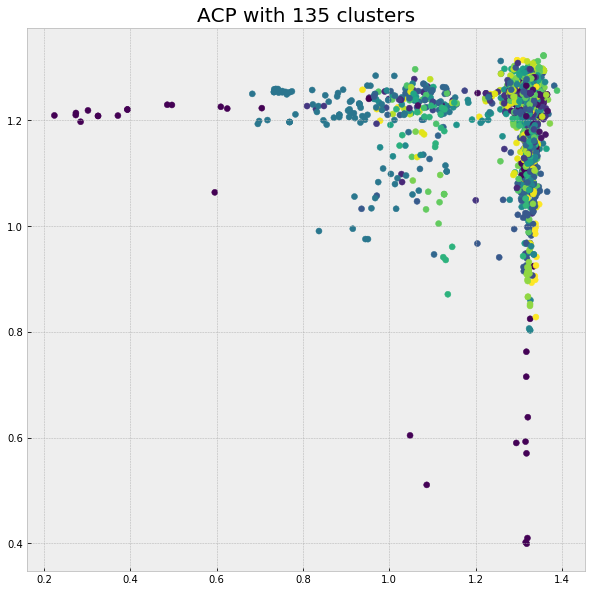

In [74]:
n_clusters = 135

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=0)
proj = kmeans.fit_transform(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("ACP with 135 clusters", fontsize="20")

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

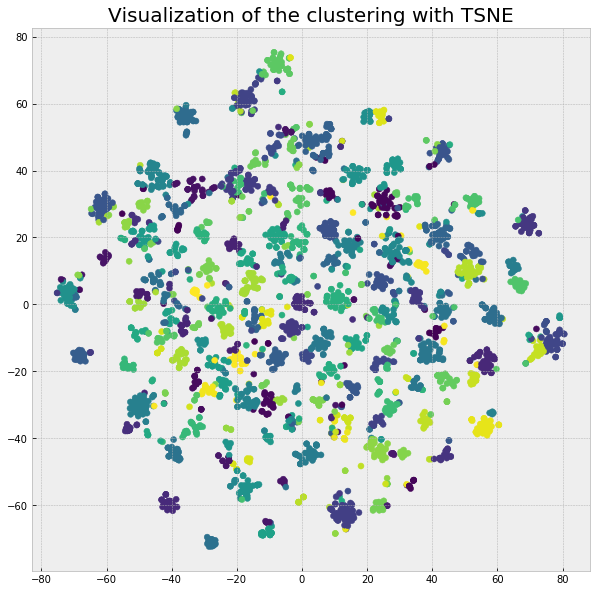

In [75]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="20")

<Figure size 432x288 with 0 Axes>

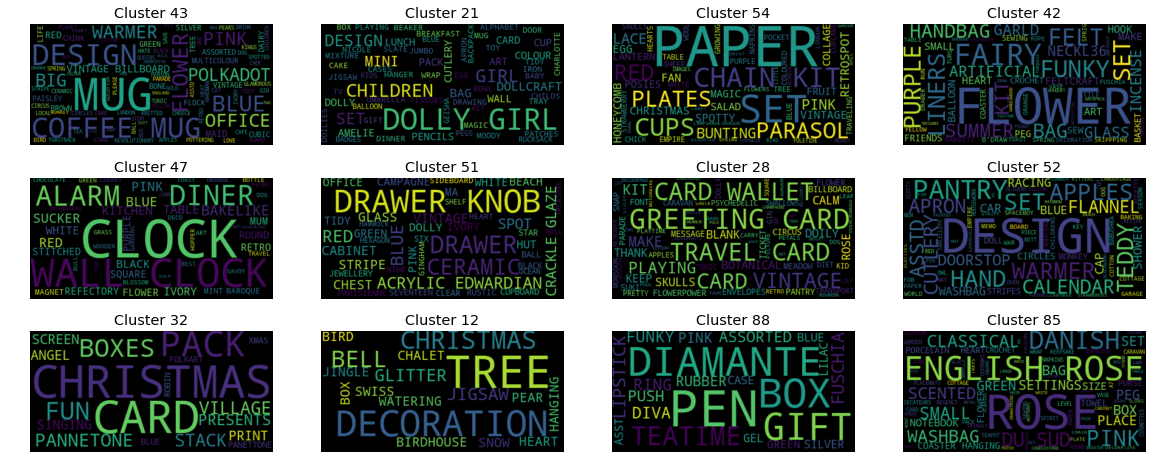

<Figure size 432x288 with 0 Axes>

In [76]:
plt.figure(figsize=(20,8))
wc = WordCloud()

for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(X[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()

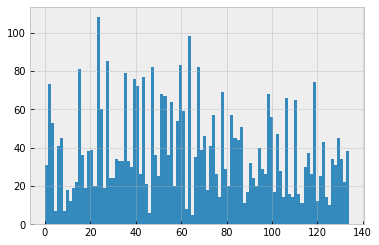

In [77]:
pd.Series(clusters).hist(bins=100)

In [78]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

In [79]:
with open('product_clusters.pickle', 'wb') as h:
    pickle.dump(dict_article_to_cluster, h)

## Creating Customer Category

#### Intermediate dataset grouped by invoices 

In [80]:
cluster = df_cleaned['Description'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Cluster").mul(df_cleaned["TotalPrice"], 0)
df2 = pd.concat([df_cleaned['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

In [81]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = lambda x:x.iloc[0]
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]


df_grouped = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

#### Final dataset grouped by customers

In [82]:
df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [83]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = ['min','max','mean']
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

In [84]:
df_grouped_final.head()

TotalPrice                   min_recency max_recency frequency  \
                  min    max       mean    <lambda>    <lambda>  <lambda>   
CustomerID                                                                  
12346             0.0    0.0   0.000000       325.0       325.0         1   
12347            13.2   45.0  23.308571         2.0       367.0         7   
12348            39.6  150.0  82.840000        75.0       358.0         4   
12349            15.0   15.0  15.000000        18.0        18.0         1   
12350            25.2   25.2  25.200000       310.0       310.0         1   

           monetary_value Quantity  Country  
                 <lambda>      sum <lambda>  
CustomerID                                   
12346                0.00    74215       35  
12347             4310.00     2458       16  
12348             1437.24     2332       12  
12349             1457.55      630       18  
12350              294.40      196       24

In [85]:
df_grouped_final.columns = ["min", "max", "mean", "min_recency", "max_recency", "frequency", "monetary_value", "quantity", "country"]

In [86]:
df_grouped_final.head()

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country
CustomerID,,,,,,,,,
12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35
12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16
12348,39.6,150.0,82.840000,75.0,358.0,4,1437.24,2332,12
12349,15.0,15.0,15.000000,18.0,18.0,1,1457.55,630,18
12350,25.2,25.2,25.200000,310.0,310.0,1,294.40,196,24


In [87]:
df2_grouped_final.head()

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
12347,0.003132,0.0,0.000000,0.004594,0.0,0.0,0.003081,0.004733,0.011582,0.0,...,0.016251,0.0,0.0,0.0,0.000000,0.006961,0.0,0.000000,0.004037,0.0
12348,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.188862,0.000000,0.0,0.011828,0.000000,0.0
12349,0.000000,0.0,0.013132,0.000000,0.0,0.0,0.000000,0.000000,0.014751,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.011938,0.0
12350,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0


### Clustering Customers 

In [88]:
X1 = df_grouped_final.as_matrix()
X2 = df2_grouped_final.as_matrix()

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

In [89]:
x = list(range(2, 12))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 2
The average silhouette_score is : 0.8857200922120357 with Std Scaling
n_clusters = 3
The average silhouette_score is : 0.8599745210145836 with Std Scaling
n_clusters = 4
The average silhouette_score is : 0.2547650579925775 with Std Scaling
n_clusters = 5
The average silhouette_score is : 0.340406740026784 with Std Scaling
n_clusters = 6
The average silhouette_score is : 0.3885779485551319 with Std Scaling
n_clusters = 7
The average silhouette_score is : 0.3971527356454849 with Std Scaling
n_clusters = 8
The average silhouette_score is : 0.40363877965963224 with Std Scaling
n_clusters = 9
The average silhouette_score is : 0.4101849793189176 with Std Scaling
n_clusters = 10
The average silhouette_score is : 0.41396819900371934 with Std Scaling
n_clusters = 11
The average silhouette_score is : 0.4091760738118158 with Std Scaling


#### We want to have at least 5, 6 clusters so we won't take 2 or 3 clusters even though they have the highest silhouette scores, 8 clusters would fit the best here. 

In [90]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30, random_state=0)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

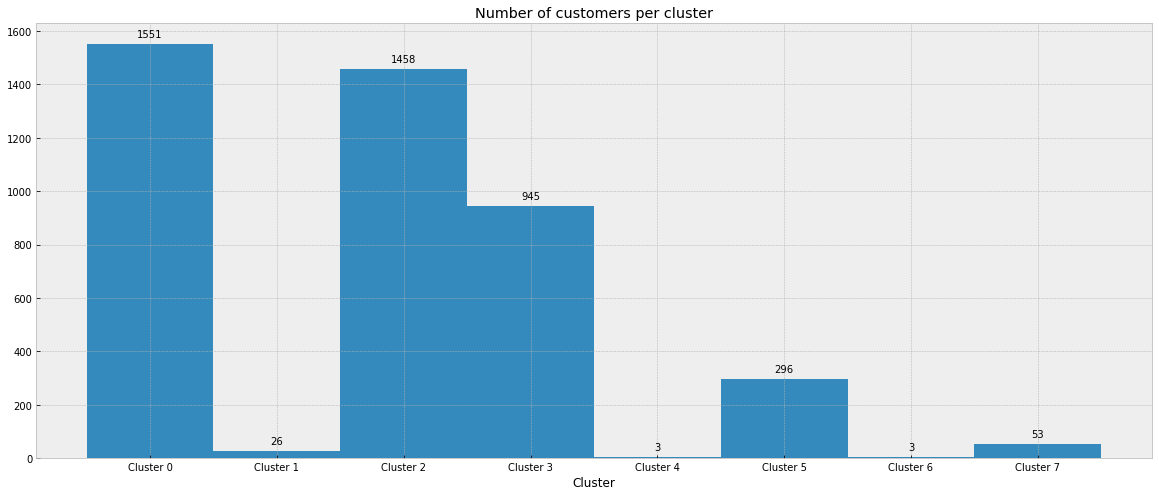

In [91]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=8)
plt.xlabel("Cluster")
plt.title("Number of customers per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(8)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [92]:
df_grouped_final["cluster"] = clusters

In [93]:
final_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
final_dataset.head()

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35,1,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16,5,...,0.016251,0.0,0.0,0.0,0.000000,0.006961,0.0,0.000000,0.004037,0.0
12348,39.6,150.0,82.840000,75.0,358.0,4,1437.24,2332,12,5,...,0.000000,0.0,0.0,0.0,0.188862,0.000000,0.0,0.011828,0.000000,0.0
12349,15.0,15.0,15.000000,18.0,18.0,1,1457.55,630,18,5,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.011938,0.0
12350,25.2,25.2,25.200000,310.0,310.0,1,294.40,196,24,3,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [94]:
final_dataset_V2 = final_dataset.reset_index()

In [95]:
final_dataset_V2.to_csv("final_dataset_V2.csv",index=False)

In [96]:
with open('df_cleaned.pickle', 'wb') as f:
    pickle.dump(df_cleaned, f)

#### Interpreting the clusters

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

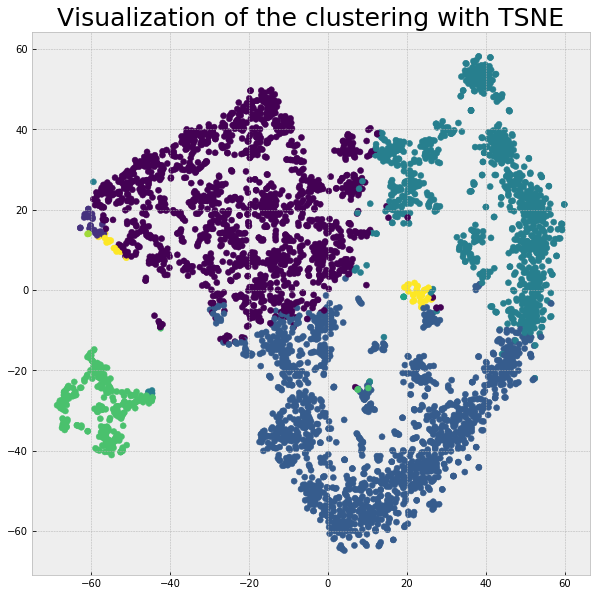

In [157]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="25")

#### Graphically the clusters are distinctive enough. Let's take a closer look at the clusters that contain few customers.

## Observing Cluster 0 

In [158]:
final_dataset[final_dataset['cluster']==0].head()

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12352,0.0,35.70,16.842857,36.0,296.0,7,1265.41,526,24,0,...,0.0,0.0,0.028923,0.0,0.000000,0.011854,0.0,0.0,0.000000,0.0
12356,25.5,102.00,51.300000,22.0,325.0,3,2487.43,1573,26,0,...,0.0,0.0,0.000000,0.0,0.012543,0.000000,0.0,0.0,0.000000,0.0
12363,15.9,69.36,42.630000,109.0,242.0,2,552.00,408,36,0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
12409,0.0,79.20,47.200000,78.0,182.0,3,11056.93,5551,32,0,...,0.0,0.0,0.000000,0.0,0.003799,0.000000,0.0,0.0,0.012698,0.0
12421,9.9,30.00,18.225000,15.0,319.0,4,639.04,478,30,0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [161]:
final_dataset[final_dataset['cluster']==0].mean().head()

min             10.441767
max             70.836776
mean            31.047408
min_recency     36.580916
max_recency    312.066409
dtype: float64

In [162]:
temp_final_df = final_dataset.reset_index()

In [163]:
cust0 = list(temp_final_df[temp_final_df['cluster']==0]['CustomerID'])

In [164]:
cluster0 = df_cleaned[df_cleaned['CustomerID'].isin(cust0)]
cluster0[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency','monetary_value']].mean()

Quantity              10.153012
UnitPrice              2.899849
QuantityCanceled       0.110372
TotalPrice            17.300751
frequency             11.190015
min_recency           24.468990
monetary_value      5537.188947
dtype: float64

In [165]:
cluster0['Description'].value_counts()[:10]

WHITE HANGING HEART T-LIGHT HOLDER    1349
JUMBO BAG RED RETROSPOT               1089
REGENCY CAKESTAND 3 TIER               977
PARTY BUNTING                          932
ASSORTED COLOUR BIRD ORNAMENT          925
LUNCH BAG RED RETROSPOT                902
LUNCH BAG  BLACK SKULL.                754
SET OF 3 CAKE TINS PANTRY DESIGN       729
LUNCH BAG CARS BLUE                    679
LUNCH BAG PINK POLKADOT                678
Name: Description, dtype: int64

In [166]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster0_grouped = cluster0.groupby("CustomerID").agg(custom_aggregation)

In [167]:
cluster0_grouped['RFMScore'].value_counts()

111    363
211    155
322    122
222    118
122     97
321     81
221     67
311     60
121     48
112     47
323     44
223     42
212     42
333     39
332     37
233     31
312     22
123     21
133     20
232     19
334     18
234     15
132      7
134      6
231      5
324      4
224      3
113      3
213      2
412      2
124      2
331      2
411      2
424      1
433      1
114      1
422      1
313      1
Name: RFMScore, dtype: int64

In [168]:
cluster0_grouped['Country'].value_counts()

35    1515
30      13
32       7
26       6
31       2
25       2
24       2
23       2
36       1
29       1
Name: Country, dtype: int64

In [169]:
cluster0['Month'].value_counts()

11    33241
12    25905
10    24727
9     22546
5     18319
3     18138
8     16705
6     16085
7     15823
4     15758
1     13992
2     13122
Name: Month, dtype: int64

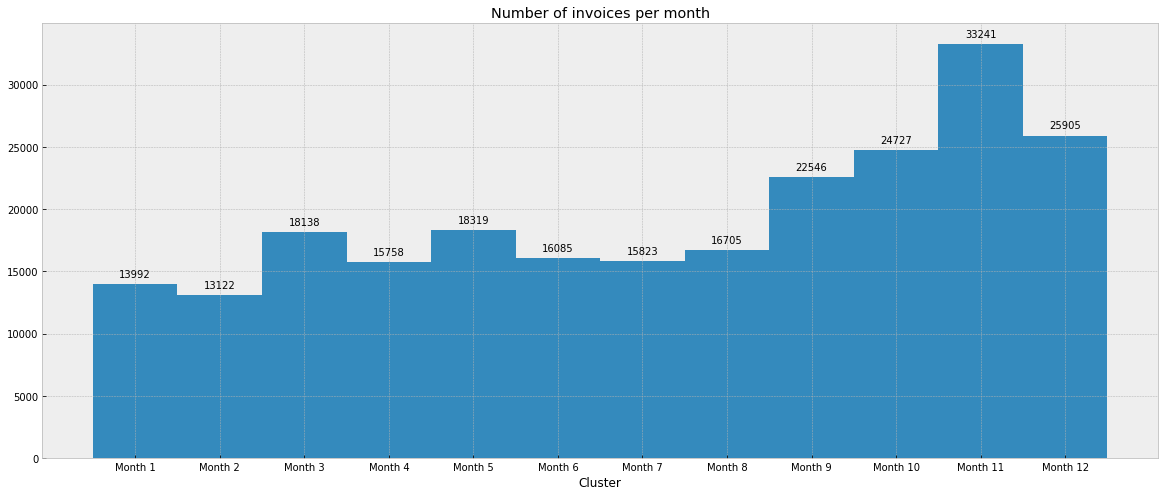

In [170]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [171]:
temp['Year'] = cluster0[cluster0['Month']==12]['InvoiceDate'].map(lambda x: x.year)
temp['Year'].value_counts()

2010.0    1100
2011.0     423
Name: Year, dtype: int64

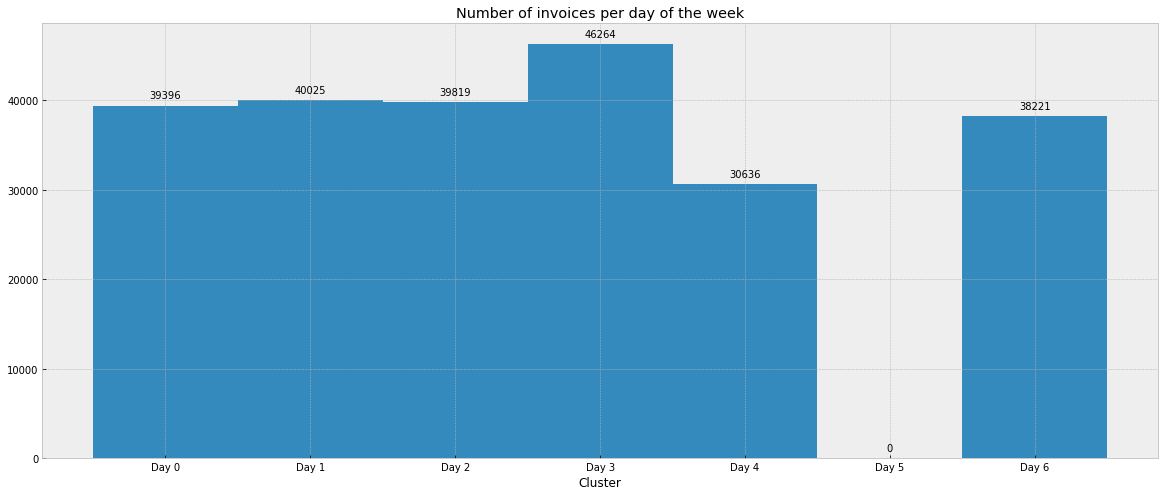

In [172]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [173]:
cluster0['Day'].nunique()

31

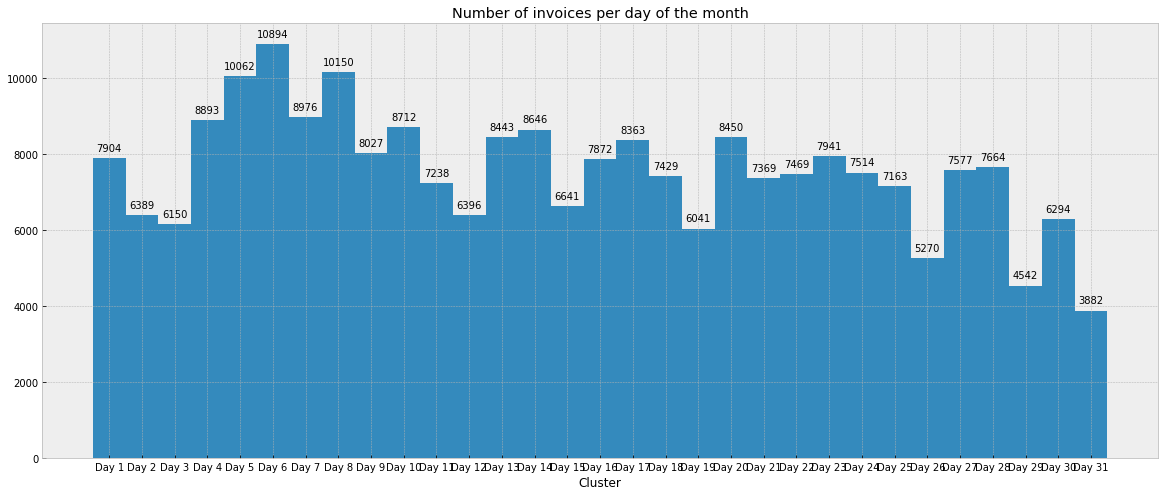

In [174]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [175]:
cluster0['Hour'].nunique()

14

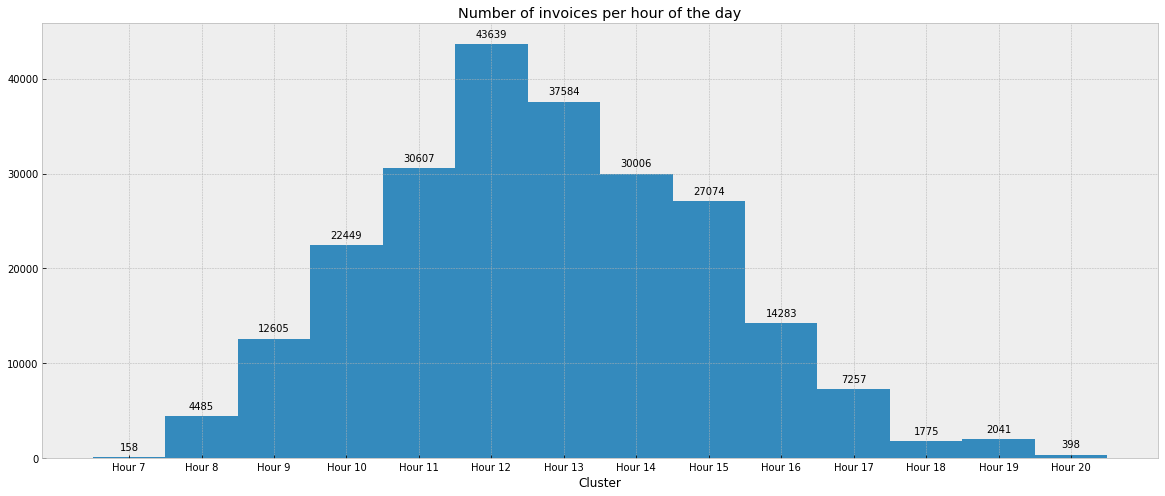

In [176]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Hour'], bins=14)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster0['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)



These customers seems to be good, since they have good RFM scores, the 4 most represented categories are (111, 211, 322, 222). They seem to be normal customers.

Key figures:

   - Min Basket Price: 10.86
   - Mean Basket Price: 30.60

   - Max Basket Price: 68.57

   - Quantity: 10.00
   - UnitPrice: 2.87
   - QuantityCanceled: 0.04
   - TotalPrice: 17.09
   - Frequency 11.134050
   - Recency 24.574626

TOP 10 bought products :

 - WHITE HANGING HEART T-LIGHT HOLDER: 1345
 - JUMBO BAG RED RETROSPOT: 1079
 - REGENCY CAKESTAND 3 TIER: 960
 - ASSORTED COLOUR BIRD ORNAMENT: 926
 - PARTY BUNTING: 924
 - LUNCH BAG RED RETROSPOT: 898
 - LUNCH BAG BLACK SKULL: 753
 - SET OF 3 CAKE TINS PANTRY DESIGN: 725
 - LUNCH BAG CARS BLUE: 679
 - LUNCH BAG PINK POLKADOT: 676



### Observing Cluster 1

In [205]:
final_dataset[final_dataset['cluster']==1].mean().head()

min              2.318462
max            690.251923
mean           154.328768
min_recency     18.730769
max_recency    360.346154
dtype: float64

In [206]:
cust1 = list(temp_final_df[temp_final_df['cluster']==1]['CustomerID'])

In [207]:
cluster1 = df_cleaned[df_cleaned['CustomerID'].isin(cust1)]
cluster1[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency','monetary_value']].mean()

Quantity               31.744638
UnitPrice               2.613462
QuantityCanceled        5.416246
TotalPrice             39.323294
frequency             120.605474
min_recency             2.747008
monetary_value      61454.936751
dtype: float64

In [208]:
cluster1['Description'].value_counts()[:10]

JUMBO BAG RED RETROSPOT               152
REGENCY CAKESTAND 3 TIER              148
WHITE HANGING HEART T-LIGHT HOLDER    131
CHILLI LIGHTS                         115
JUMBO BAG PINK POLKADOT                98
PAPER BUNTING RETROSPOT                97
LUNCH BAG  BLACK SKULL.                95
GUMBALL COAT RACK                      94
LUNCH BAG RED RETROSPOT                93
JUMBO BAG STRAWBERRY                   90
Name: Description, dtype: int64

### Observing Cluster 2 

In [197]:
final_dataset[final_dataset['cluster']==2].mean().head()

min            20.310508
max            33.404047
mean           26.003750
min_recency    49.735940
max_recency    86.520576
dtype: float64

In [198]:
cust2 = list(temp_final_df[temp_final_df['cluster']==2]['CustomerID'])

In [199]:
cluster2 = df_cleaned[df_cleaned['CustomerID'].isin(cust2)]
cluster2[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency','monetary_value']].mean()

Quantity               9.043122
UnitPrice              2.692642
QuantityCanceled       0.077464
TotalPrice            13.585805
frequency              3.080891
min_recency           36.041578
monetary_value      1186.942549
dtype: float64

In [200]:
cluster2['Description'].value_counts()[:10]

PAPER CHAIN KIT 50'S CHRISTMAS        269
BAKING SET 9 PIECE RETROSPOT          263
WHITE HANGING HEART T-LIGHT HOLDER    250
ASSORTED COLOUR BIRD ORNAMENT         248
REX CASH+CARRY JUMBO SHOPPER          225
HOT WATER BOTTLE KEEP CALM            216
REGENCY CAKESTAND 3 TIER              211
RABBIT NIGHT LIGHT                    201
GARDENERS KNEELING PAD KEEP CALM      195
SPOTTY BUNTING                        191
Name: Description, dtype: int64

### Observing Cluster 3 

In [184]:
final_dataset[final_dataset['cluster']==3].mean().head()

min             23.638751
max             35.159799
mean            28.947747
min_recency    250.768254
max_recency    281.724868
dtype: float64

In [185]:
cust3 = list(temp_final_df[temp_final_df['cluster']==3]['CustomerID'])

In [186]:
cluster3 = df_cleaned[df_cleaned['CustomerID'].isin(cust3)]
cluster3[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency','monetary_value']].mean()

Quantity              8.292591
UnitPrice             3.381203
QuantityCanceled      0.125464
TotalPrice           15.186075
frequency             2.656366
min_recency         236.675489
monetary_value      860.278054
dtype: float64

In [187]:
cluster3['Description'].value_counts()[:10]

WHITE HANGING HEART T-LIGHT HOLDER    230
REGENCY CAKESTAND 3 TIER              188
PARTY BUNTING                         138
ASSORTED COLOUR BIRD ORNAMENT         129
JAM MAKING SET WITH JARS              104
NATURAL SLATE HEART CHALKBOARD        103
REX CASH+CARRY JUMBO SHOPPER          103
SET OF 3 CAKE TINS PANTRY DESIGN      101
HEART OF WICKER SMALL                  98
HEART OF WICKER LARGE                  86
Name: Description, dtype: int64

### Observing Cluster 4 

In [214]:
final_dataset[final_dataset['cluster']==4].mean().head()

min            3386.640000
max            3386.640000
mean           3386.640000
min_recency     162.666667
max_recency     162.666667
dtype: float64

In [215]:
cust4 = list(temp_final_df[temp_final_df['cluster']==4]['CustomerID'])

In [216]:
cluster4 = df_cleaned[df_cleaned['CustomerID'].isin(cust4)]
cluster4[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency','monetary_value']].mean()

Quantity            3203.333333
UnitPrice              1.430000
QuantityCanceled       0.000000
TotalPrice          3386.640000
frequency              1.000000
min_recency          162.666667
monetary_value      3386.640000
dtype: float64

In [217]:
cluster4['Description'].value_counts()[:10]

SMALL POPCORN HOLDER               1
EMPIRE DESIGN ROSETTE              1
METAL SIGN TAKE IT OR LEAVE IT     1
Name: Description, dtype: int64

### Observing Cluster 5 

In [218]:
final_dataset[final_dataset['cluster']==5].mean().head()

min             20.476791
max             60.115101
mean            33.816071
min_recency     91.858108
max_recency    222.472973
dtype: float64

In [219]:
cust5 = list(temp_final_df[temp_final_df['cluster']==5]['CustomerID'])

In [220]:
cluster5 = df_cleaned[df_cleaned['CustomerID'].isin(cust5)]
cluster5[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency','monetary_value']].mean()

Quantity              13.804910
UnitPrice              2.895844
QuantityCanceled       0.119572
TotalPrice            23.689686
frequency              7.883096
min_recency           46.556347
monetary_value      4496.309126
dtype: float64

In [221]:
cluster5['Description'].value_counts()[:10]

ROUND SNACK BOXES SET OF4 WOODLAND     233
REGENCY CAKESTAND 3 TIER               163
PLASTERS IN TIN WOODLAND ANIMALS       151
ROUND SNACK BOXES SET OF 4 FRUITS      147
RED TOADSTOOL LED NIGHT LIGHT          145
PLASTERS IN TIN CIRCUS PARADE          143
SPACEBOY LUNCH BOX                     137
PLASTERS IN TIN SPACEBOY               120
RABBIT NIGHT LIGHT                     120
WOODLAND CHARLOTTE BAG                 111
Name: Description, dtype: int64

### Observing Cluster 6 

In [222]:
final_dataset[final_dataset['cluster']==6].mean().head()

min              13.120000
max            3812.360000
mean            513.055091
min_recency       3.000000
max_recency     362.666667
dtype: float64

In [223]:
cust6 = list(temp_final_df[temp_final_df['cluster']==6]['CustomerID'])

In [224]:
cluster6 = df_cleaned[df_cleaned['CustomerID'].isin(cust6)]
cluster6[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency','monetary_value']].mean()

Quantity               117.102437
UnitPrice                2.829152
QuantityCanceled         0.170964
TotalPrice             258.501219
frequency               67.816319
min_recency              1.678559
monetary_value      265709.695959
dtype: float64

In [225]:
cluster6['Description'].value_counts()[:10]

SPACEBOY LUNCH BOX                     25
ROUND SNACK BOXES SET OF4 WOODLAND     24
CREAM HEART CARD HOLDER                22
WOOD BLACK BOARD ANT WHITE FINISH      19
DOLLY GIRL LUNCH BOX                   19
BLACK HEART CARD HOLDER                17
ROUND SNACK BOXES SET OF 4 FRUITS      17
SPACEBOY BIRTHDAY CARD                 16
JUMBO BAG RED RETROSPOT                15
WOODLAND CHARLOTTE BAG                 15
Name: Description, dtype: int64

### Observing Cluster 7 

In [226]:
final_dataset[final_dataset['cluster']==7].mean().head()

min             284.266038
max            1092.233585
mean            589.189415
min_recency     100.415094
max_recency     237.509434
dtype: float64

In [230]:
cust7 = list(temp_final_df[temp_final_df['cluster']==7]['CustomerID'])

In [231]:
cluster7 = df_cleaned[df_cleaned['CustomerID'].isin(cust7)]
cluster7[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency','monetary_value']].mean()

Quantity              136.901712
UnitPrice               3.226842
QuantityCanceled        7.727330
TotalPrice            188.227806
frequency              17.381737
min_recency            23.978440
monetary_value      14597.175219
dtype: float64

In [232]:
cluster7['Description'].value_counts()[:10]

RECORD FRAME 7" SINGLE SIZE           25
BLACK RECORD COVER FRAME              22
REGENCY CAKESTAND 3 TIER              19
JUMBO BAG RED RETROSPOT               19
RED  HARMONICA IN BOX                 19
WHITE HANGING HEART T-LIGHT HOLDER    18
SOLDIERS EGG CUP                      16
EDWARDIAN PARASOL NATURAL             16
PARTY BUNTING                         16
STRAWBERRY CERAMIC TRINKET BOX        15
Name: Description, dtype: int64